In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import os
import random
import re
from nltk.sentiment import SentimentIntensityAnalyzer
import datetime
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\amoueye\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import utils
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
df= pd.read_csv('../Data/sentiment_labels.csv')

In [4]:
df.head()

date  adj_close     volume ticker  1_day_return  predicted_label
0  2017-01-31  28.308922  196804000   AAPL     -0.002307                0
1  2017-01-31  28.308922  196804000   AAPL     -0.002307                1
2  2017-01-31  28.308922  196804000   AAPL     -0.002307                1
3  2017-01-31  28.308922  196804000   AAPL     -0.002307                2
4  2017-01-31  28.308922  196804000   AAPL     -0.002307                0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124244 entries, 0 to 124243
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   date             124244 non-null  object 
 1   adj_close        124244 non-null  float64
 2   volume           124244 non-null  int64  
 3   ticker           124244 non-null  object 
 4   1_day_return     124244 non-null  float64
 5   predicted_label  124244 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 5.7+ MB


In [6]:
df['date'] =  pd.to_datetime(df['date'])

In [7]:
tickers= list(df['ticker'].unique())

In [8]:
tickers

['AAPL',
 'ADDYY',
 'AMZN',
 'BMWYY',
 'BP',
 'DIS',
 'EBAY',
 'F',
 'GOOGL',
 'HNDAF',
 'HP',
 'IBM',
 'INTC',
 'META',
 'MSFT',
 'NEXT',
 'NFLX',
 'NKE',
 'PARA',
 'PYPL',
 'RYAAY',
 'SBUX',
 'SONY',
 'TM',
 'TRI',
 'UPS',
 'V',
 'WMT']

In [9]:
def get_stock_info (tic):
    df_tic= df[df.ticker== tic]. groupby('date')[['1_day_return','predicted_label']].mean()
    return  df_tic

In [10]:
get_stock_info('AAPL')

1_day_return  predicted_label
date                                     
2017-01-31     -0.002307         1.189189
2017-02-01      0.057476         1.175824
2017-02-28      0.000438         1.204969
2017-03-01      0.020030         1.232143
2017-03-31     -0.001880         1.198953
...                  ...              ...
2018-10-19      0.015002         1.375887
2018-10-23      0.009339         1.287500
2018-10-24     -0.035520         1.375000
2018-10-25      0.021428         1.285714
2018-10-30      0.004969         1.310580

[71 rows x 2 columns]

In [11]:
def stock_plot(tic):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    get_stock_info(tic)['predicted_label'].plot(ax= ax1, c= 'g')
    get_stock_info(tic)['1_day_return'].plot(ax= ax2, c= 'b')

    ax1.set_xlabel('date')
    ax1.set_ylabel('sentiment labels', color='g')
    ax2.set_ylabel('stock return', color='b')
    plt.xticks(rotation=90)
    plt.title('Stock Return and Sentiment Labels for {}'.format(tic))
    plt.show();

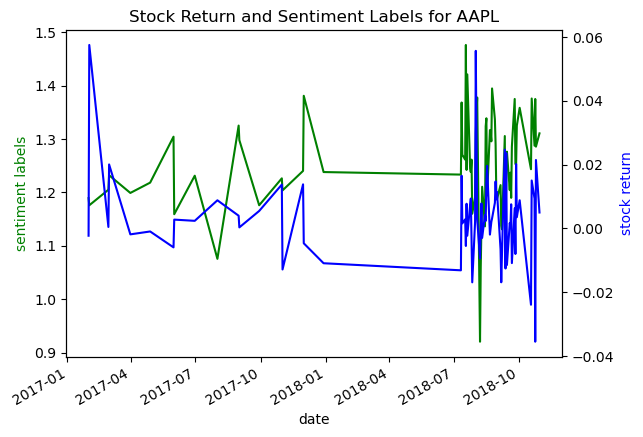

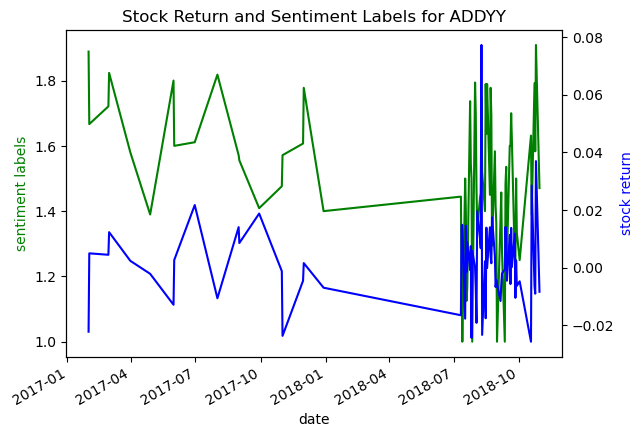

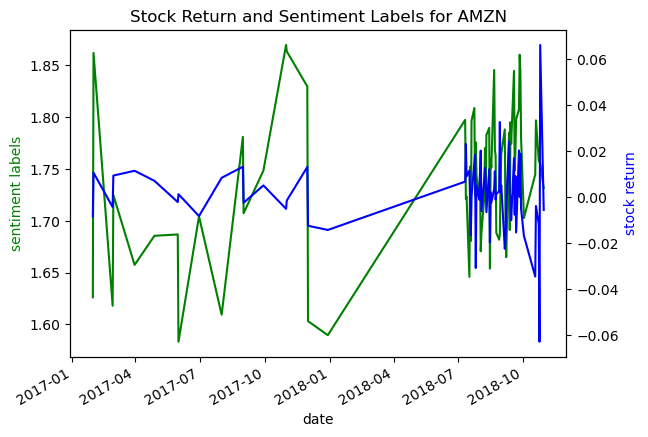

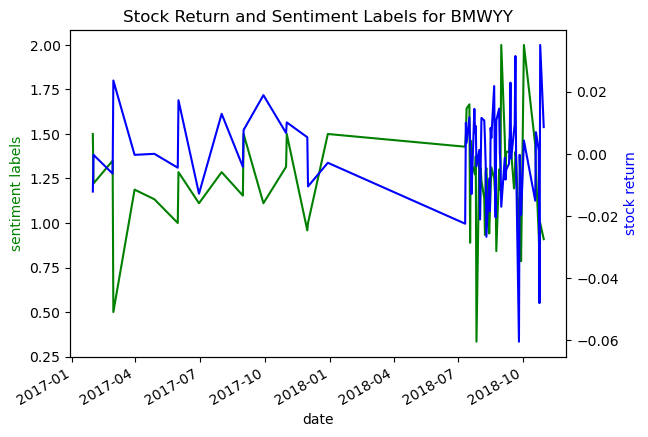

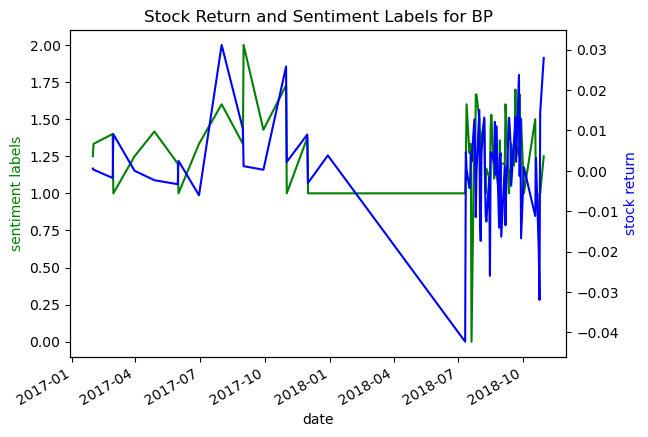

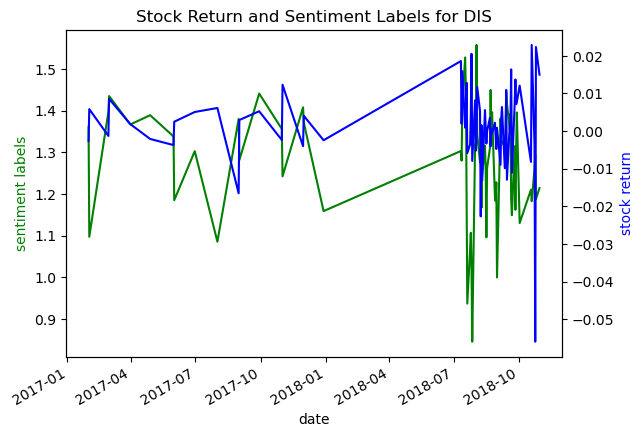

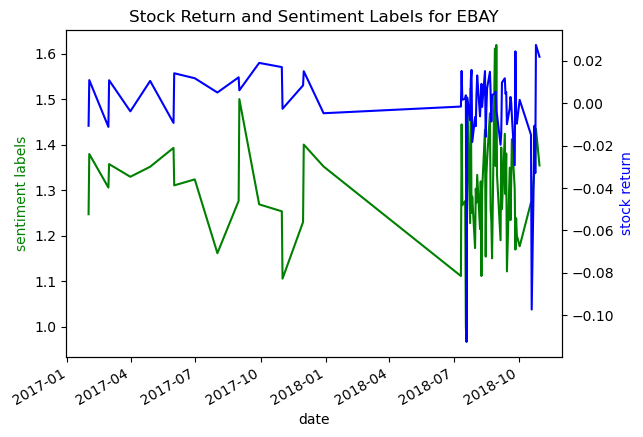

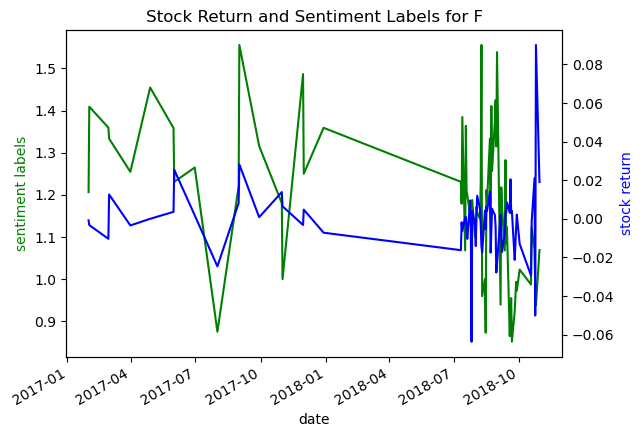

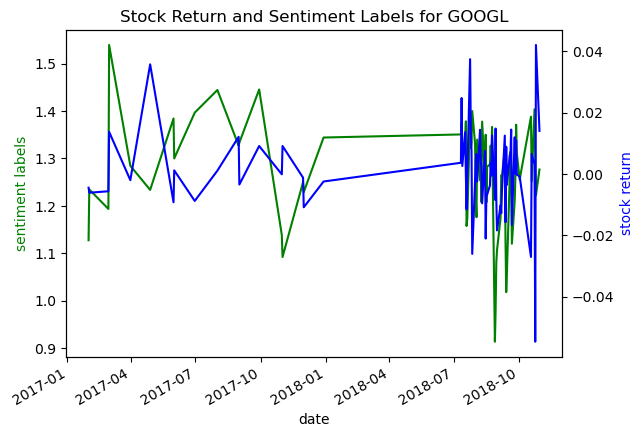

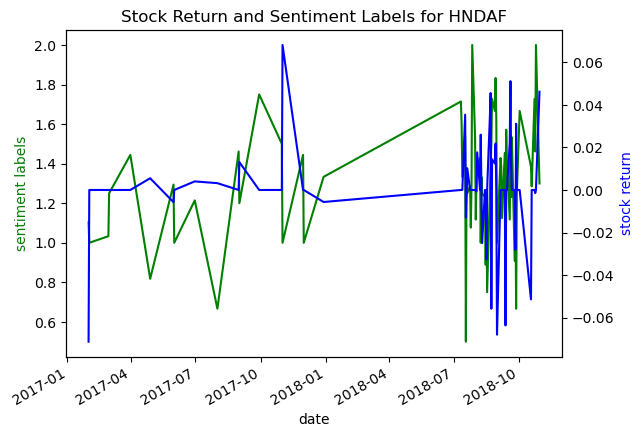

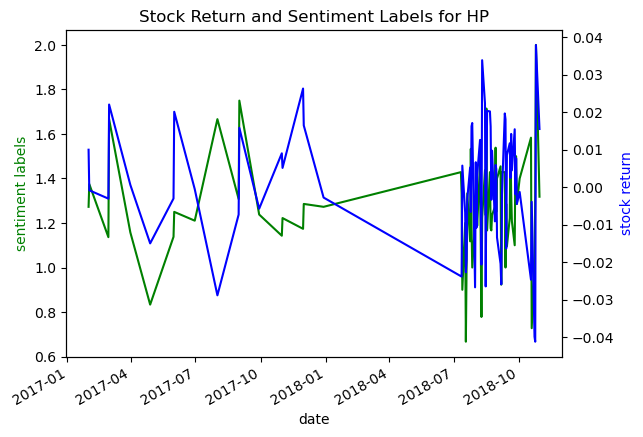

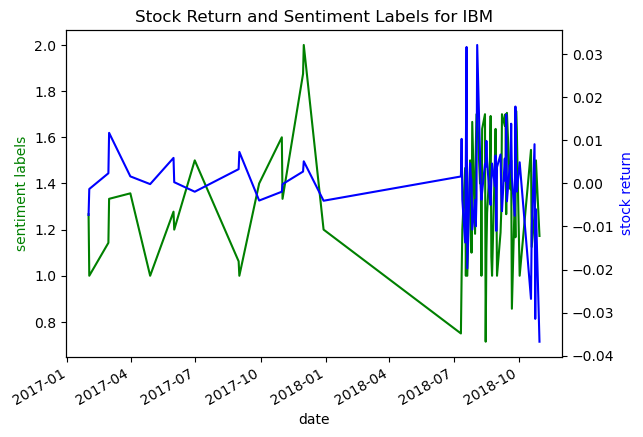

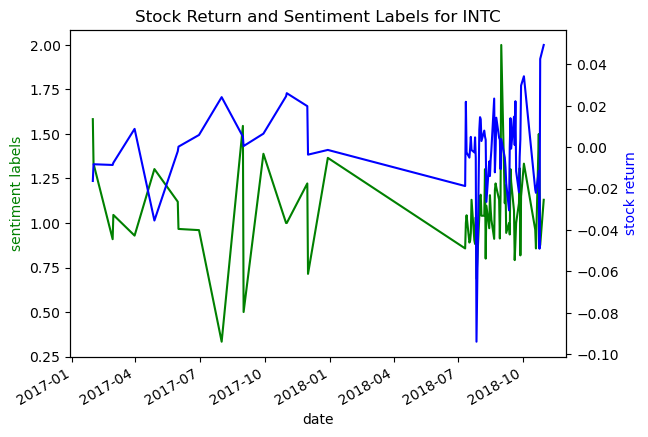

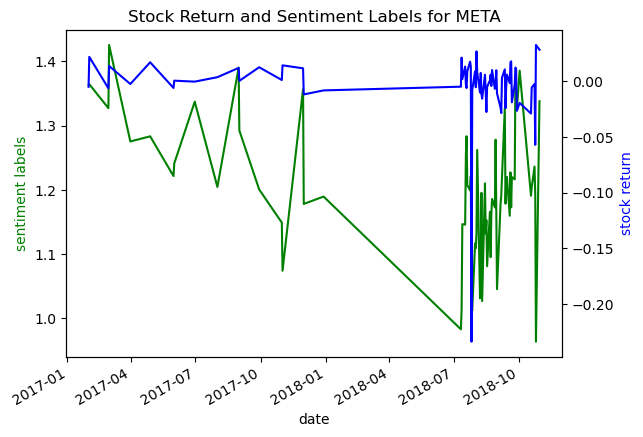

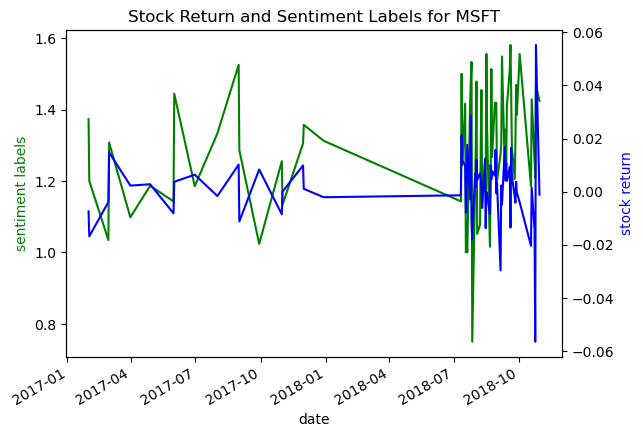

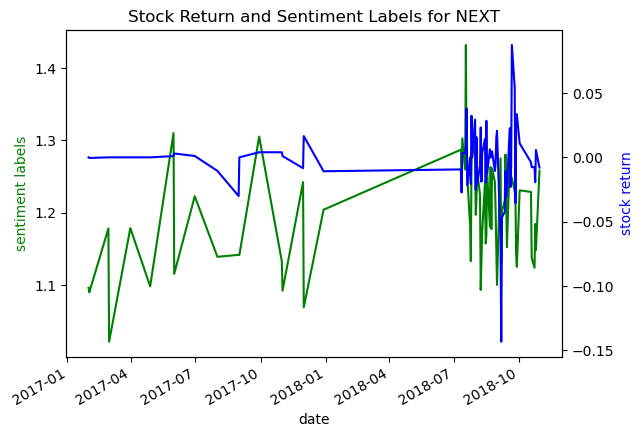

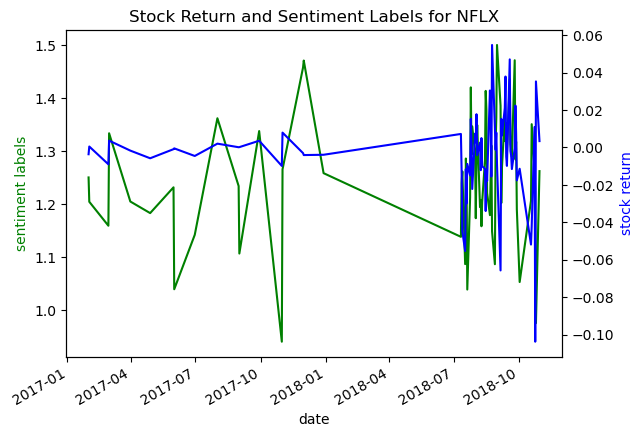

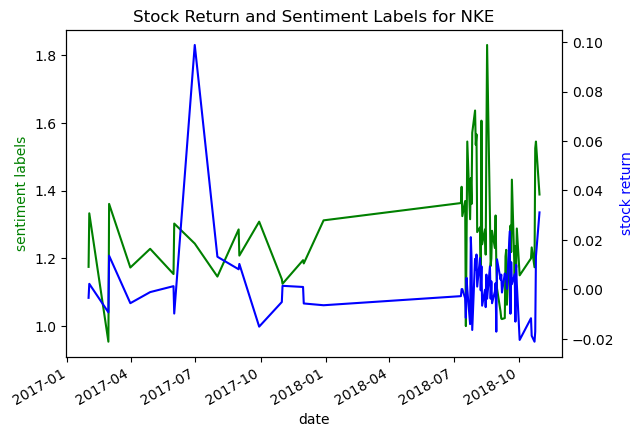

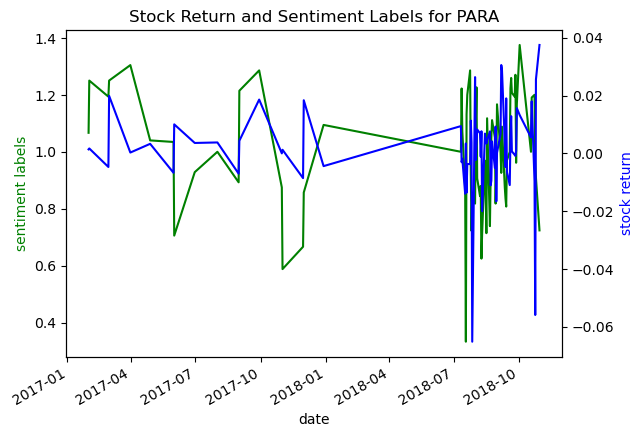

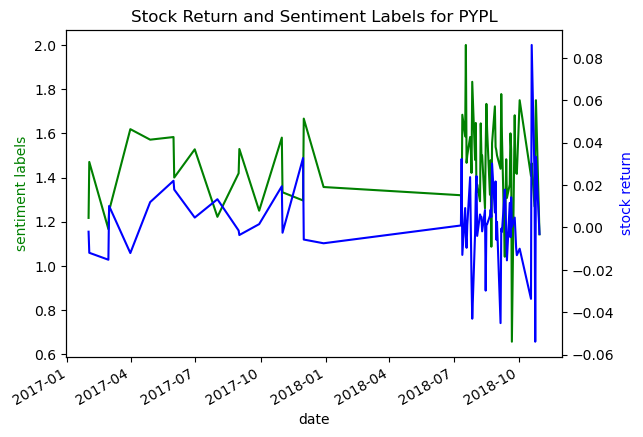

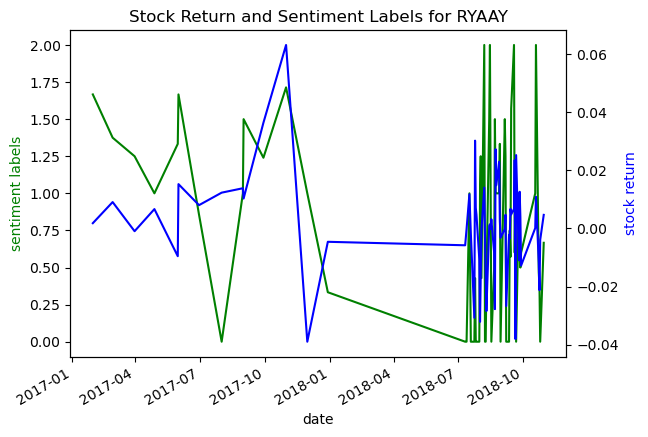

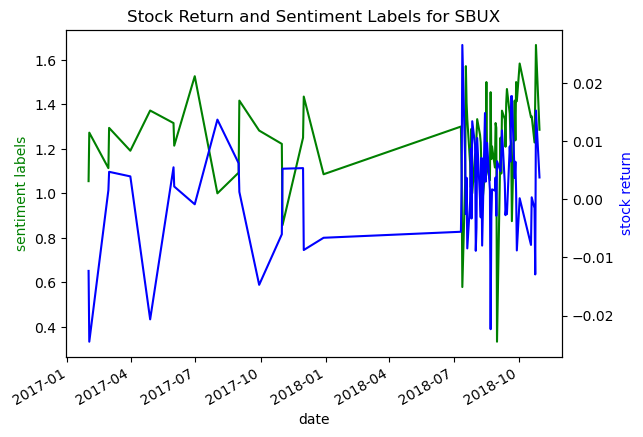

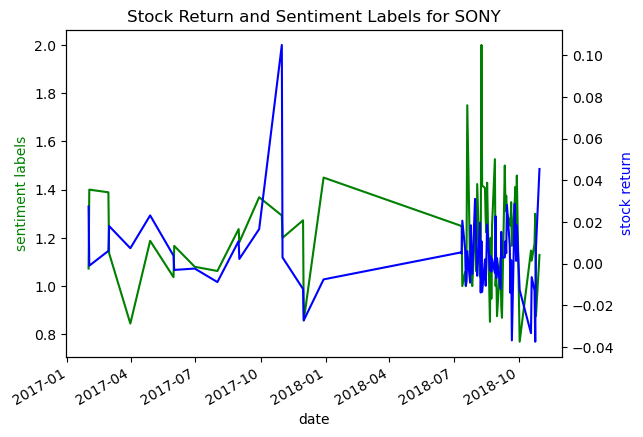

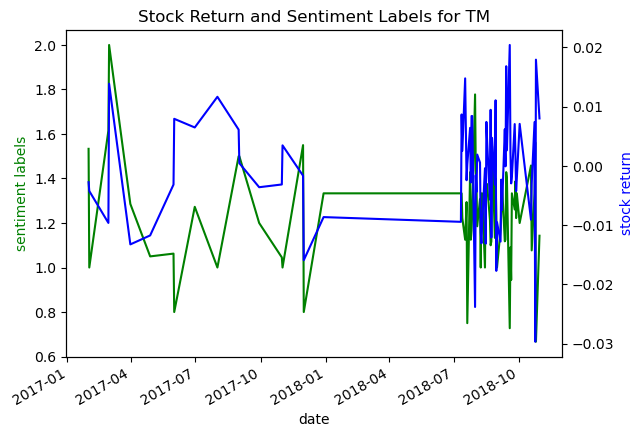

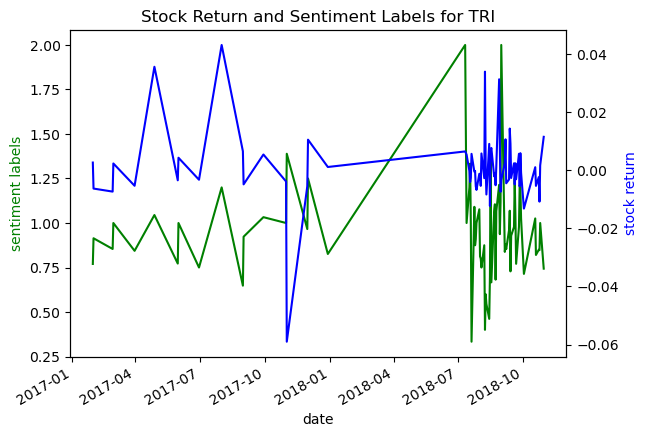

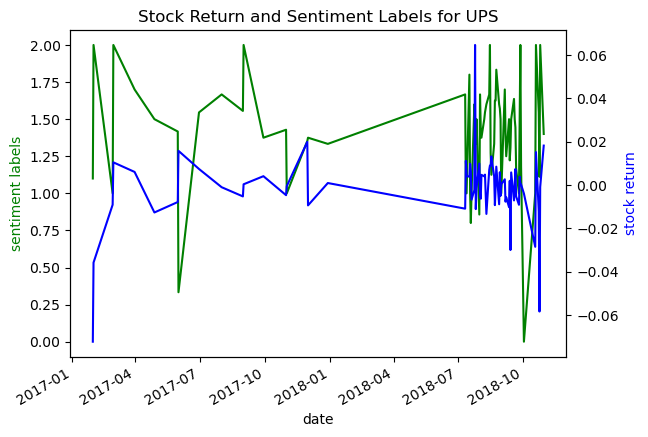

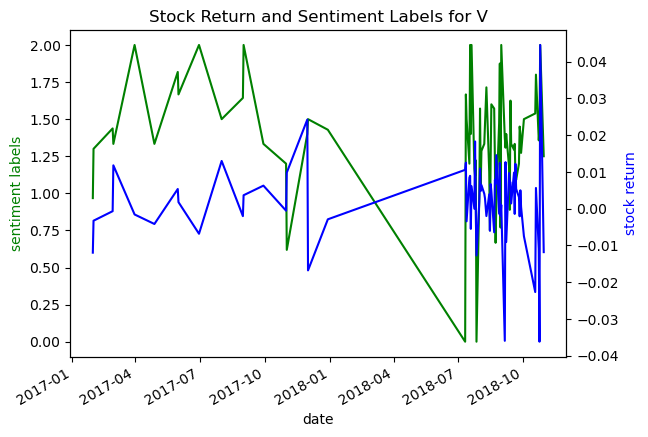

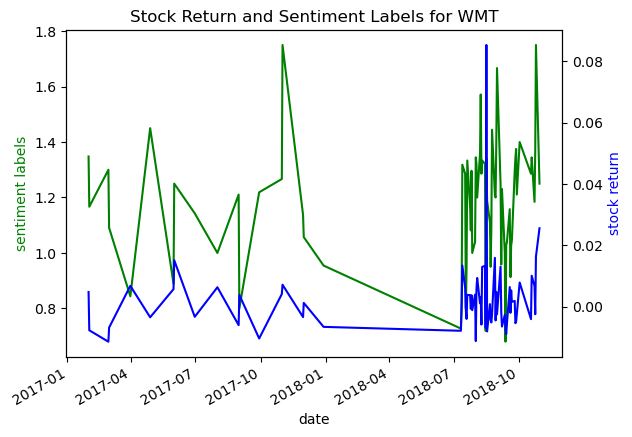

In [12]:
for tic in tickers: 
    stock_plot(tic)

# 5. Prepare dataset for LSTM model

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124244 entries, 0 to 124243
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   date             124244 non-null  datetime64[ns]
 1   adj_close        124244 non-null  float64       
 2   volume           124244 non-null  int64         
 3   ticker           124244 non-null  object        
 4   1_day_return     124244 non-null  float64       
 5   predicted_label  124244 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 5.7+ MB


In [16]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [17]:
# create a function to convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df1 = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df1.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df1.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        return agg

## 6- Define and fit the model for one stock

In [18]:
df1= get_stock_info('AMZN')

In [19]:
#Convert dataframe to arrays and ensure all data is float

values= df1.values
values= values.astype('float32')

In [20]:
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

In [21]:
# frame as supervised learning
n_days= 10
n_features= 2
reframed = series_to_supervised(scaled, n_days, 1)

>We have (10 * 2) + 2 columns in our framed dataset now. We will take 10*2 or 20 columns as input for the observations of all features across the previous 10 days. We will take just the "treated_water_ph" variable as output at the following hour.

In [22]:
print(reframed.head())

    var1(t-10)  var2(t-10)  var1(t-9)  var2(t-9)  var1(t-8)  var2(t-8)  \
10   -0.156293   -0.700619   0.138862   0.946082  -0.092427  -0.757576   
11    0.138862    0.946082  -0.092427  -0.757576   0.119761  -0.010909   
12   -0.092427   -0.757576   0.119761  -0.010909   0.152023  -0.482471   
13    0.119761   -0.010909   0.152023  -0.482471   0.084430  -0.286223   
14    0.152023   -0.482471   0.084430  -0.286223  -0.058798  -0.277136   

    var1(t-7)  var2(t-7)  var1(t-6)  var2(t-6)  ...  var1(t-4)  var2(t-4)  \
10   0.119761  -0.010909   0.152023  -0.482471  ...  -0.058798  -0.277136   
11   0.152023  -0.482471   0.084430  -0.286223  ...  -0.005665  -1.000000   
12   0.084430  -0.286223  -0.058798  -0.277136  ...  -0.153394  -0.155425   
13  -0.058798  -0.277136  -0.005665  -1.000000  ...   0.104528  -0.818183   
14  -0.005665  -1.000000  -0.153394  -0.155425  ...   0.179343   0.380733   

    var1(t-3)  var2(t-3)  var1(t-2)  var2(t-2)  var1(t-1)  var2(t-1)  \
10  -0.005665  -1.00

In [23]:
reframed.shape

(61, 22)

In [118]:
# split into train and test sets
values = reframed.values
n_test_hours = int(0.25 * reframed.shape[0])
train = values[n_test_hours:, :]
test = values[:n_test_hours, :]


In [119]:

# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

(46, 20) 46 (46,)


In [120]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(46, 10, 2) (46,) (15, 10, 2) (15,)


In [121]:
# design network
model = Sequential()
model.add(LSTM(300, input_shape=(train_X.shape[1], train_X.shape[2]))) #200 neurons in the first hidden layer, input shape will be 12 time steps with 55 features
model.add(Dropout(0.3))
# model.add(Dense(23, activation= 'ReLU')) #1 neuron in the output layer
# model.add(Dropout(0.3))
model.add(Dense(1, activation= 'linear')) #1 neuron in the output layer
model.compile(loss='mse', optimizer='adam', metrics= ['mse','mae'] )
# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=10, validation_data=(test_X, test_y), verbose=1, shuffle=False)


Epoch 1/150
5/5 [==============================] - 10s 396ms/step - loss: 0.0891 - mse: 0.0891 - mae: 0.2072 - val_loss: 0.0268 - val_mse: 0.0268 - val_mae: 0.1370
Epoch 2/150
5/5 [==============================] - 0s 49ms/step - loss: 0.0840 - mse: 0.0840 - mae: 0.1969 - val_loss: 0.0293 - val_mse: 0.0293 - val_mae: 0.1465
Epoch 3/150
5/5 [==============================] - 0s 55ms/step - loss: 0.0834 - mse: 0.0834 - mae: 0.2002 - val_loss: 0.0312 - val_mse: 0.0312 - val_mae: 0.1542
Epoch 4/150
5/5 [==============================] - 0s 86ms/step - loss: 0.0803 - mse: 0.0803 - mae: 0.1980 - val_loss: 0.0345 - val_mse: 0.0345 - val_mae: 0.1631
Epoch 5/150
5/5 [==============================] - 0s 50ms/step - loss: 0.0777 - mse: 0.0777 - mae: 0.1941 - val_loss: 0.0419 - val_mse: 0.0419 - val_mae: 0.1812
Epoch 6/150
5/5 [==============================] - 0s 50ms/step - loss: 0.0814 - mse: 0.0814 - mae: 0.2011 - val_loss: 0.0477 - val_mse: 0.0477 - val_mae: 0.1915
Epoch 7/150
5/5 [=========

5/5 [==============================] - 0s 63ms/step - loss: 0.0411 - mse: 0.0411 - mae: 0.1613 - val_loss: 0.0653 - val_mse: 0.0653 - val_mae: 0.2265
Epoch 102/150
5/5 [==============================] - 0s 59ms/step - loss: 0.0433 - mse: 0.0433 - mae: 0.1602 - val_loss: 0.0527 - val_mse: 0.0527 - val_mae: 0.1984
Epoch 103/150
5/5 [==============================] - 0s 78ms/step - loss: 0.0388 - mse: 0.0388 - mae: 0.1578 - val_loss: 0.0403 - val_mse: 0.0403 - val_mae: 0.1740
Epoch 104/150
5/5 [==============================] - 0s 73ms/step - loss: 0.0511 - mse: 0.0511 - mae: 0.1614 - val_loss: 0.0325 - val_mse: 0.0325 - val_mae: 0.1453
Epoch 105/150
5/5 [==============================] - 0s 55ms/step - loss: 0.0341 - mse: 0.0341 - mae: 0.1436 - val_loss: 0.0321 - val_mse: 0.0321 - val_mae: 0.1560
Epoch 106/150
5/5 [==============================] - 0s 51ms/step - loss: 0.0570 - mse: 0.0570 - mae: 0.1819 - val_loss: 0.0368 - val_mse: 0.0368 - val_mae: 0.1673
Epoch 107/150
5/5 [===========

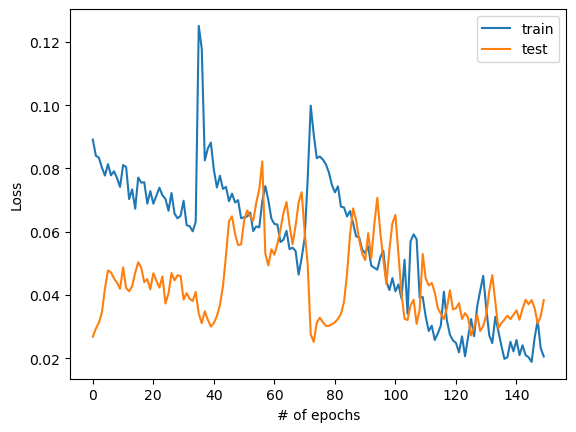

In [123]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.show()

In [136]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 300)               363600    
                                                                 
 dropout_11 (Dropout)        (None, 300)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 301       
                                                                 
Total params: 363,901
Trainable params: 363,901
Non-trainable params: 0
_________________________________________________________________


## 7- Evaluate Model

In [124]:

# make a prediction
yhat_test = model.predict(test_X, verbose=0)
yhat_train = model.predict(train_X, verbose=0)


In [125]:
test_X.shape, train_X.shape

((15, 10, 2), (46, 10, 2))

In [126]:
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
train_X = train_X.reshape((train_X.shape[0], n_days*n_features))


In [127]:
# invert scaling for forecast
inv_yhat_test = np.concatenate((yhat_test, test_X[:, -1:]), axis=1)
inv_yhat_test = scaler.inverse_transform(inv_yhat_test)
inv_yhat_test = inv_yhat_test[:,0]


inv_yhat_train = np.concatenate((yhat_train, train_X[:, -1:]), axis=1)
inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
inv_yhat_train = inv_yhat_train[:,0]

In [128]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y_test = np.concatenate((test_y, test_X[:, -1:]), axis=1)
inv_y_test = scaler.inverse_transform(inv_y_test)
inv_y_test = inv_y_test[:,0]


train_y = train_y.reshape((len(train_y), 1))
inv_y_train = np.concatenate((train_y, train_X[:, -1:]), axis=1)
inv_y_train = scaler.inverse_transform(inv_y_train)
inv_y_train = inv_y_train[:,0]

In [129]:
# calculate RMSE
rmse_test = np.sqrt(mean_squared_error(inv_y_test, inv_yhat_test))
rmse_train = np.sqrt(mean_squared_error(inv_y_train, inv_yhat_train))
print('Train RMSE is {:.3f} and Test RMSE is {:.3f}'.format(rmse_train, rmse_test))
# print('Test RMSE: %.3f' % rmse)

Train RMSE is 0.009 and Test RMSE is 0.013


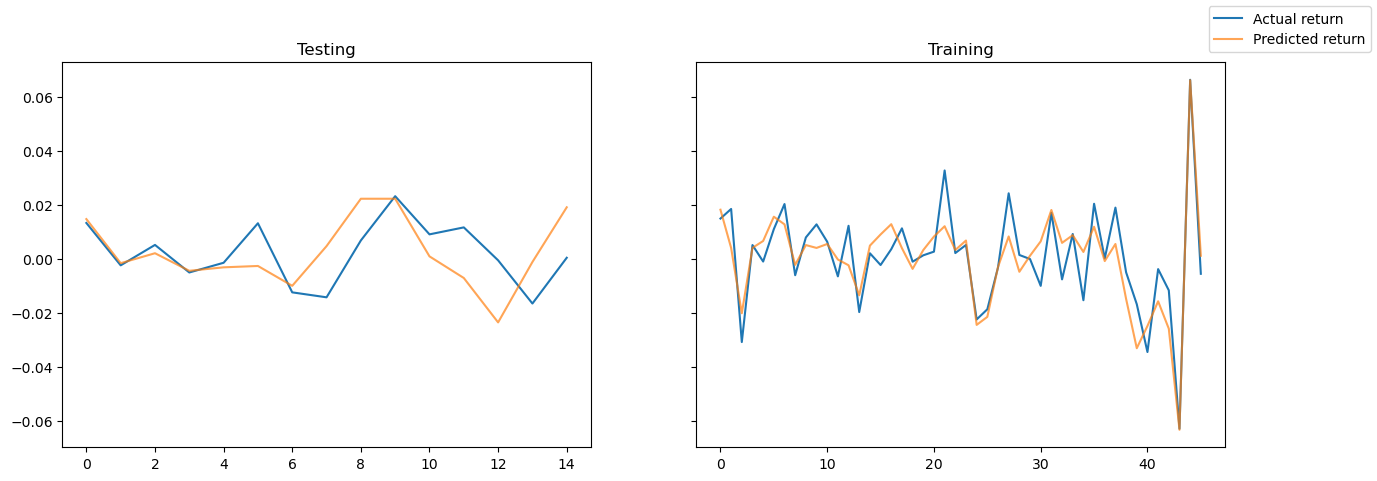

In [130]:
# plot results
fig, ax= plt.subplots(1, 2, figsize=(15,5), sharey= True)
ax[0].plot(inv_y_test)
ax[0].plot(inv_yhat_test, alpha=0.7)
ax[1].plot(inv_y_train)
ax[1].plot(inv_yhat_train, alpha=0.7)

ax[0].title.set_text('Testing')
ax[1].title.set_text('Training')

fig.legend(labels= ['Actual return', 'Predicted return'])
plt.show()

-----------------------------------------------

## 8- Define and fit the model for all stocks


In [133]:
def stock_prediction(tickers):
    for tic in tickers:
        df_tic= get_stock_info(tic)
        print(tic)

        #Convert dataframe to arrays and ensure all data is float
        values= df_tic.values
        values= values.astype('float32')

        # normalize features
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaled = scaler.fit_transform(values)

        # frame as supervised learning
        n_days= 10
        n_features= 2
        reframed = series_to_supervised(scaled, n_days, 1)
        
        # split into train and test sets
        values = reframed.values
        n_test_hours = int(0.25 * reframed.shape[0])
        train = values[n_test_hours:, :]
        test = values[:n_test_hours, :]
        
        # split into input and outputs
        n_obs = n_days * n_features
        train_X, train_y = train[:, :n_obs], train[:, -n_features]
        test_X, test_y = test[:, :n_obs], test[:, -n_features]
#         print(train_X.shape, len(train_X), train_y.shape)

        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
        test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
#         print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


       # design network
        model = Sequential()
        model.add(LSTM(300, input_shape=(train_X.shape[1], train_X.shape[2]))) #200 neurons in the first hidden layer, input shape will be 12 time steps with 55 features
        model.add(Dropout(0.3))
        # model.add(Dense(23, activation= 'ReLU')) #1 neuron in the output layer
        # model.add(Dropout(0.3))
        model.add(Dense(1, activation= 'linear')) #1 neuron in the output layer
        model.compile(loss='mse', optimizer='adam', metrics= ['mse','mae'] )
        # fit network
        history = model.fit(train_X, train_y, epochs=150, batch_size=10, validation_data=(test_X, test_y), verbose=0, shuffle=False)

        
        # make a prediction
        yhat_test = model.predict(test_X, verbose=0)
        yhat_train = model.predict(train_X, verbose=0)


        test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
        train_X = train_X.reshape((train_X.shape[0], n_days*n_features))


        # invert scaling for forecast
        inv_yhat_test = np.concatenate((yhat_test, test_X[:, -1:]), axis=1)
        inv_yhat_test = scaler.inverse_transform(inv_yhat_test)
        inv_yhat_test = inv_yhat_test[:,0]


        inv_yhat_train = np.concatenate((yhat_train, train_X[:, -1:]), axis=1)
        inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
        inv_yhat_train = inv_yhat_train[:,0]

        # invert scaling for actual
        test_y = test_y.reshape((len(test_y), 1))
        inv_y_test = np.concatenate((test_y, test_X[:, -1:]), axis=1)
        inv_y_test = scaler.inverse_transform(inv_y_test)
        inv_y_test = inv_y_test[:,0]


        train_y = train_y.reshape((len(train_y), 1))
        inv_y_train = np.concatenate((train_y, train_X[:, -1:]), axis=1)
        inv_y_train = scaler.inverse_transform(inv_y_train)
        inv_y_train = inv_y_train[:,0]

        # calculate RMSE
        rmse_test = np.sqrt(mean_squared_error(inv_y_test, inv_yhat_test))
        rmse_train = np.sqrt(mean_squared_error(inv_y_train, inv_yhat_train))
        print('Train RMSE is {:.3f} and Test RMSE is {:.3f}'.format(rmse_train, rmse_test))

        # plot results
        fig, ax= plt.subplots(1, 2, figsize=(15,5), sharey= True)
        ax[0].plot(inv_y_test)
        ax[0].plot(inv_yhat_test, alpha=0.7)
        ax[1].plot(inv_y_train)
        ax[1].plot(inv_yhat_train, alpha=0.7)

        ax[0].title.set_text('Testing')
        ax[1].title.set_text('Training')

        fig.legend(labels= ['Actual return', 'Predicted return'])
        plt.show()


AAPL
Train RMSE is 0.011 and Test RMSE is 0.010


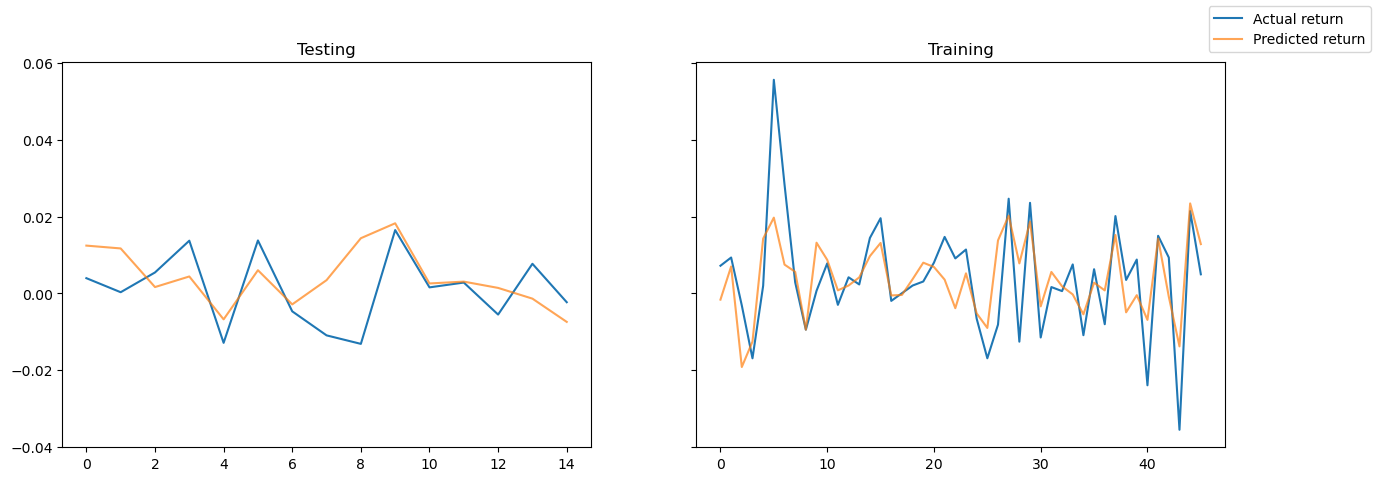

ADDYY
Train RMSE is 0.006 and Test RMSE is 0.013


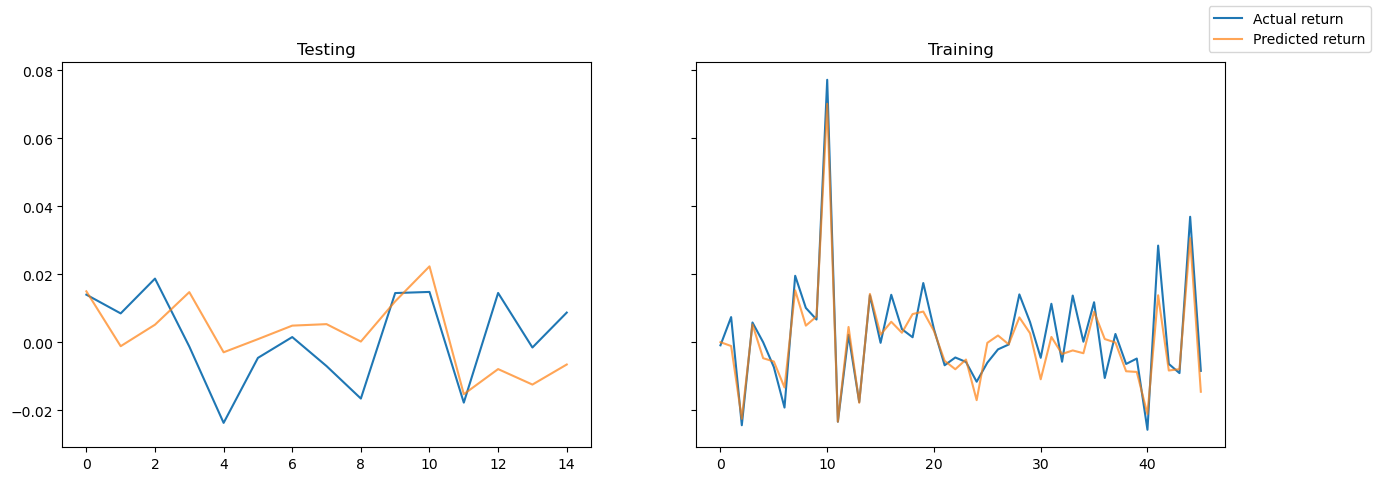

AMZN
Train RMSE is 0.009 and Test RMSE is 0.013


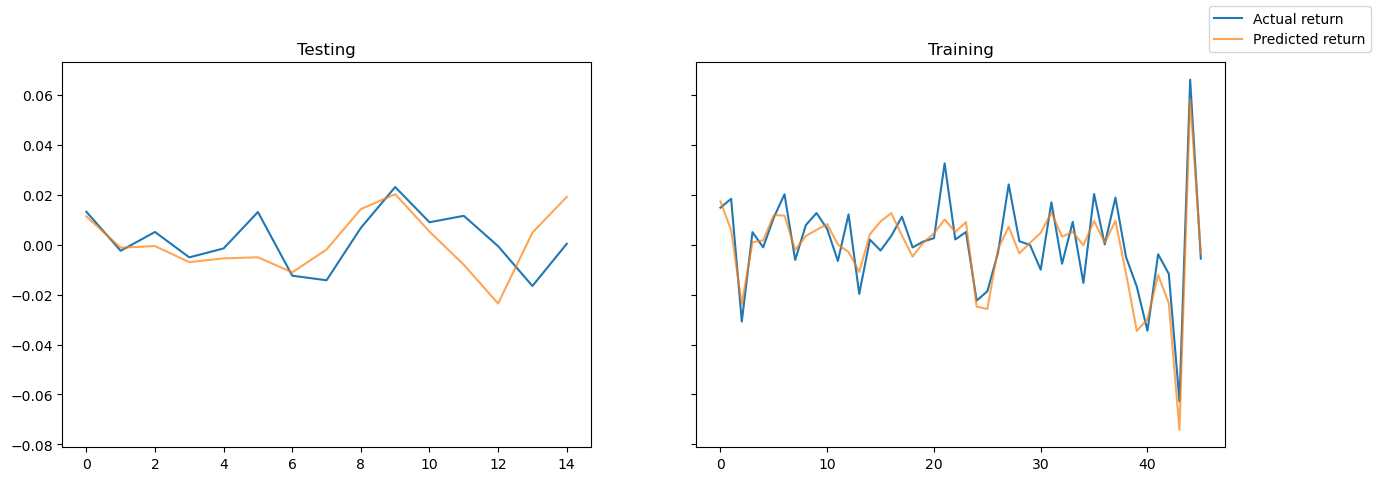

BMWYY
Train RMSE is 0.006 and Test RMSE is 0.022


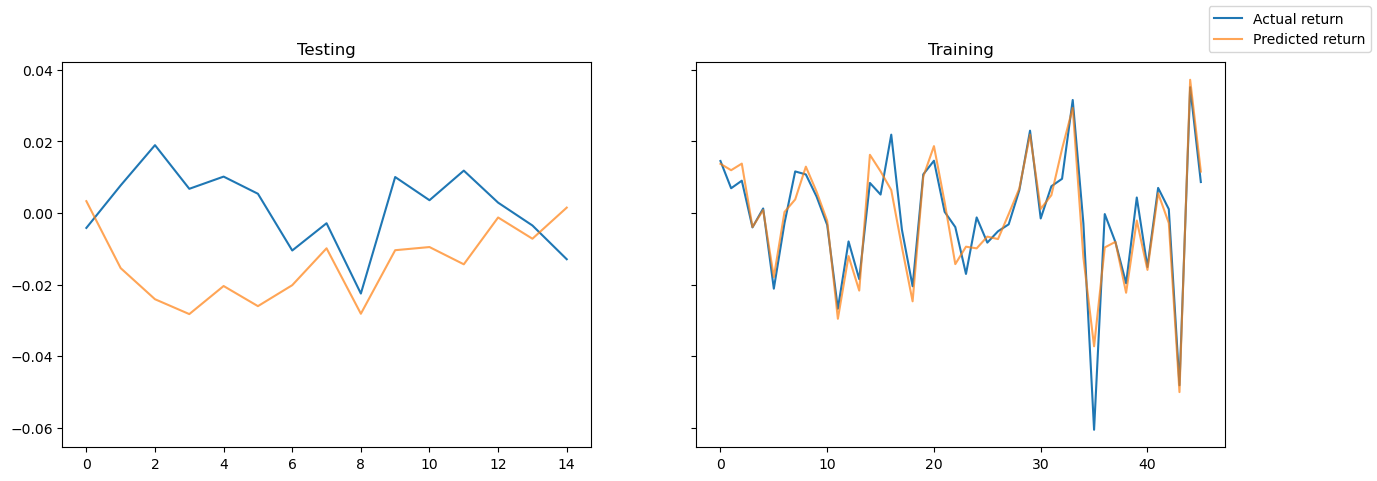

BP
Train RMSE is 0.008 and Test RMSE is 0.018


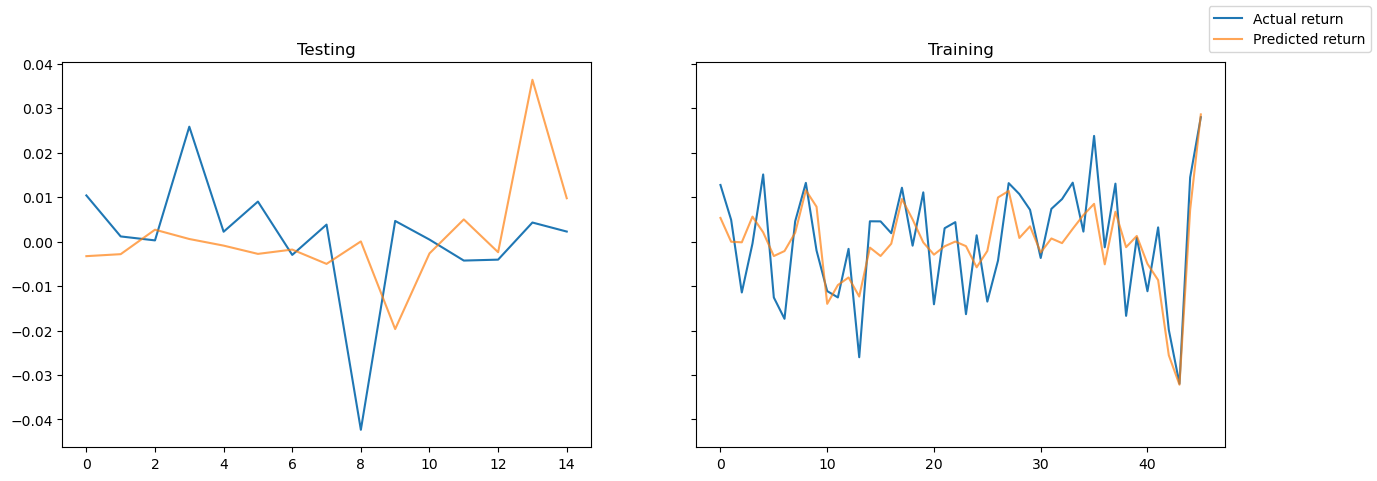

DIS
Train RMSE is 0.009 and Test RMSE is 0.011


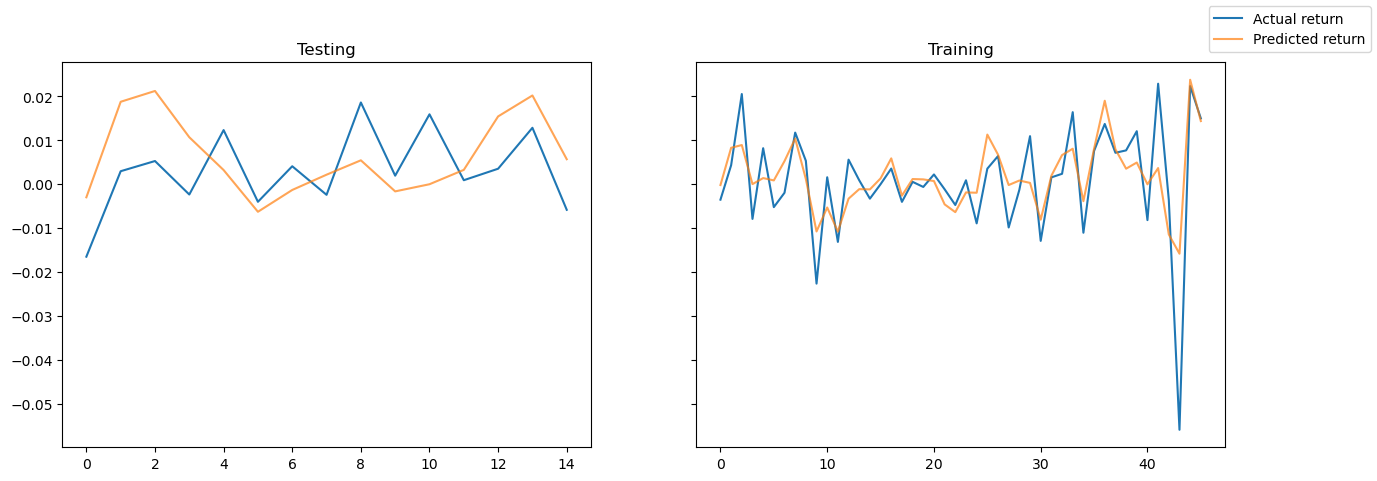

EBAY
Train RMSE is 0.012 and Test RMSE is 0.032


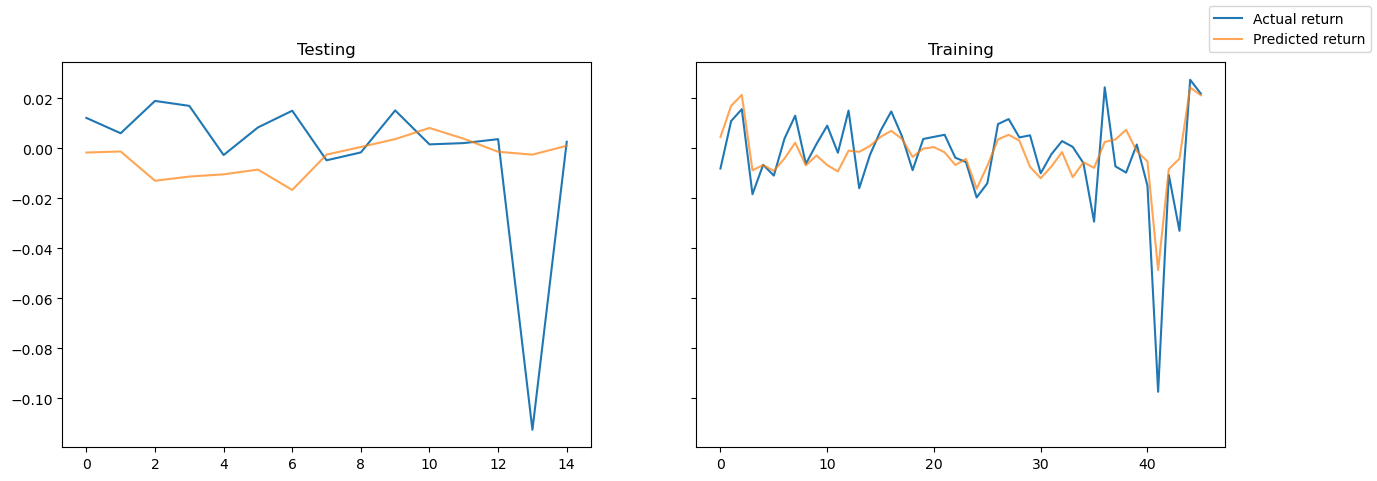

F
Train RMSE is 0.016 and Test RMSE is 0.020


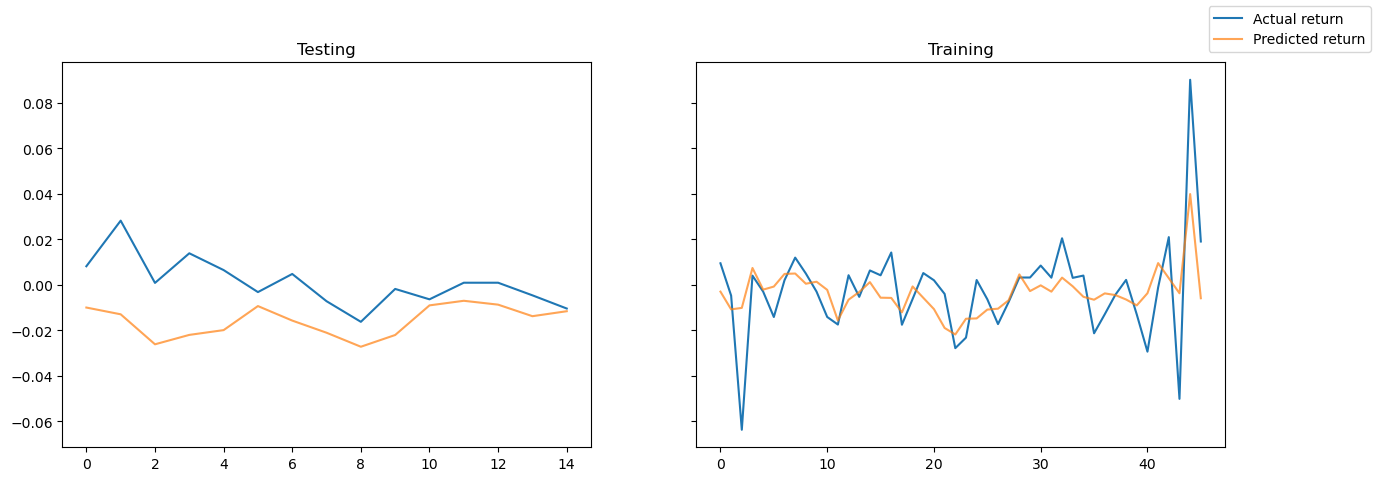

GOOGL
Train RMSE is 0.007 and Test RMSE is 0.030


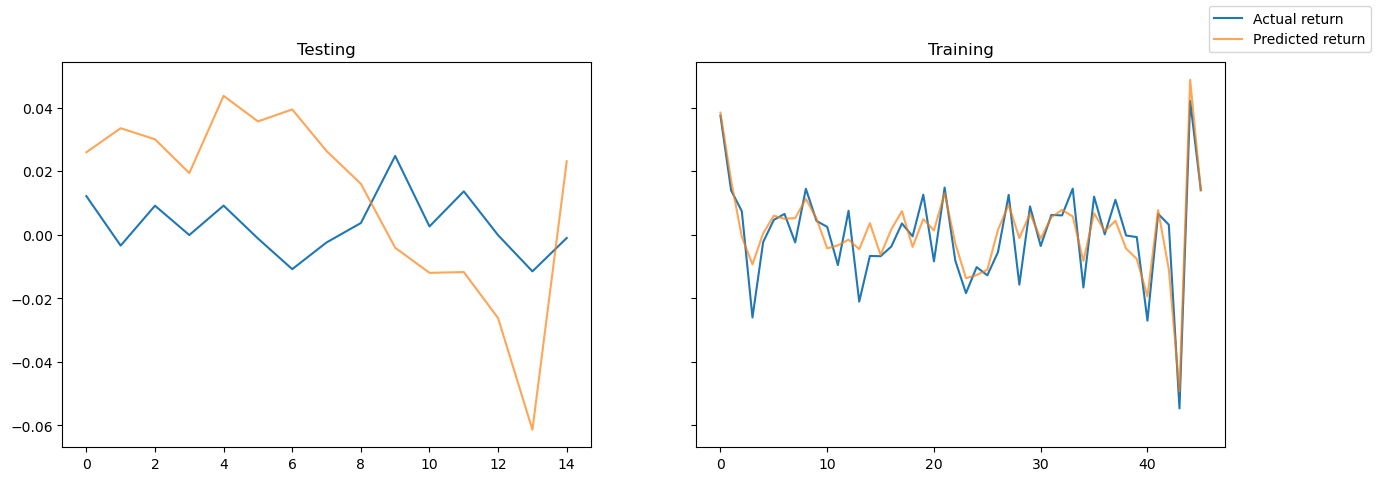

HNDAF
Train RMSE is 0.015 and Test RMSE is 0.043


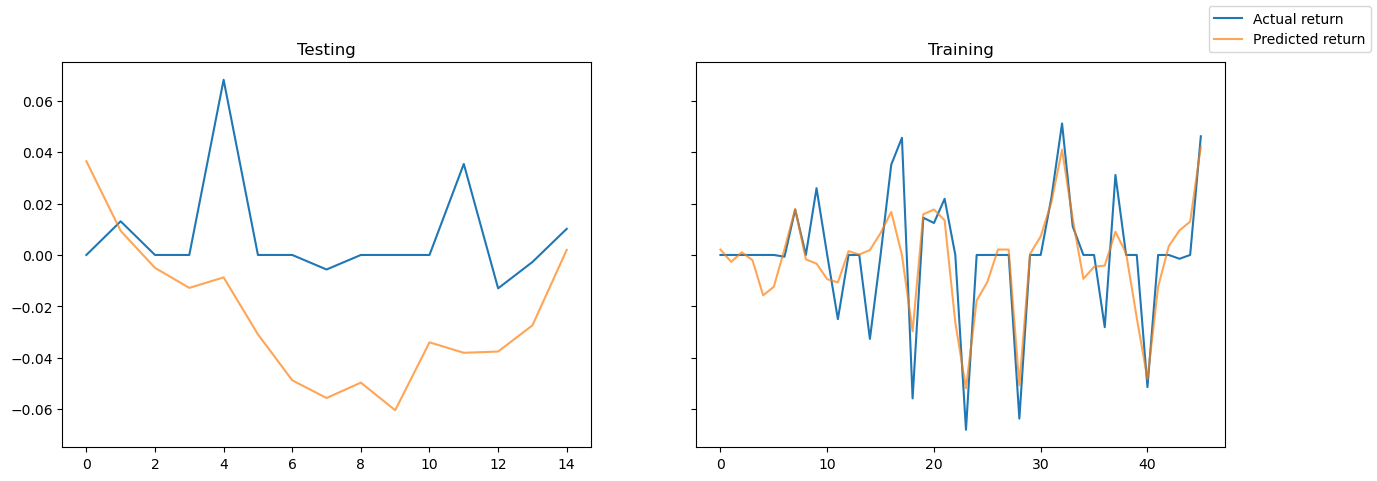

HP
Train RMSE is 0.004 and Test RMSE is 0.022


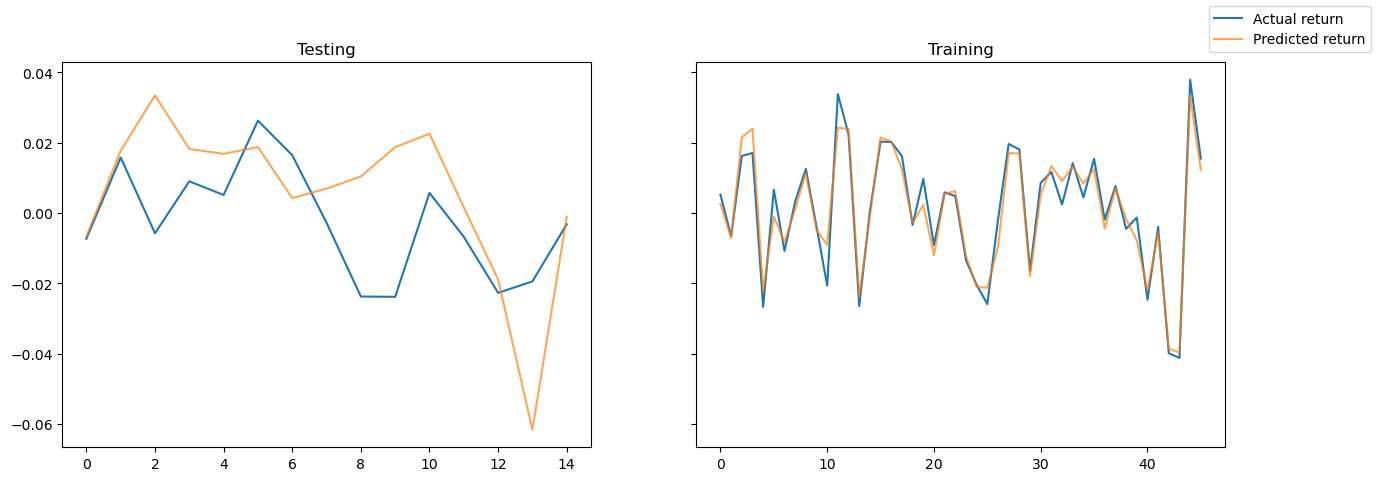

IBM
Train RMSE is 0.004 and Test RMSE is 0.020


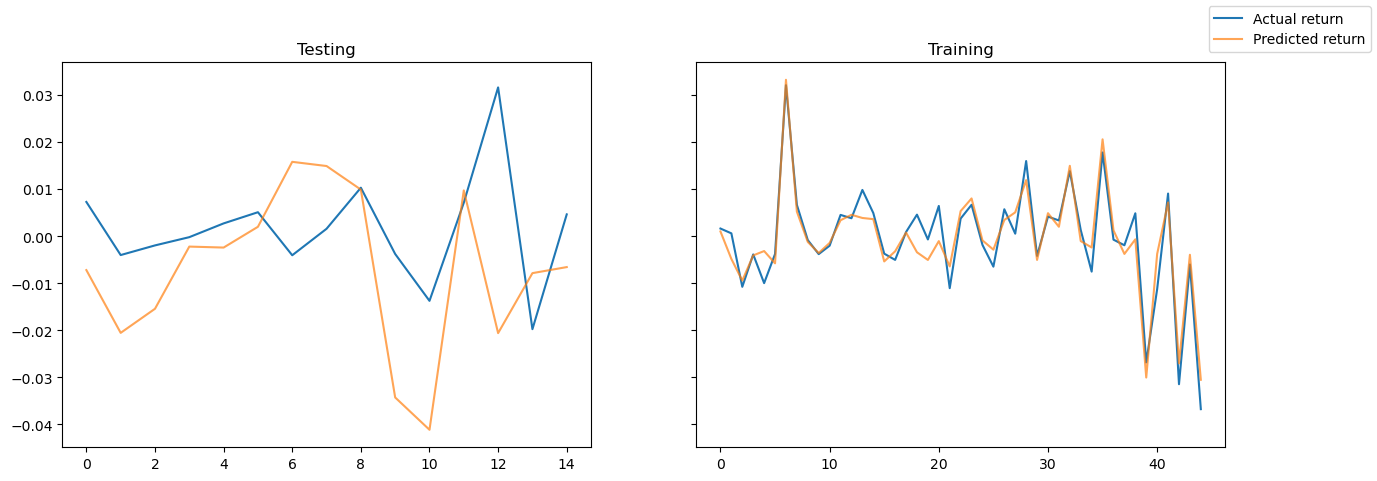

INTC
Train RMSE is 0.016 and Test RMSE is 0.029


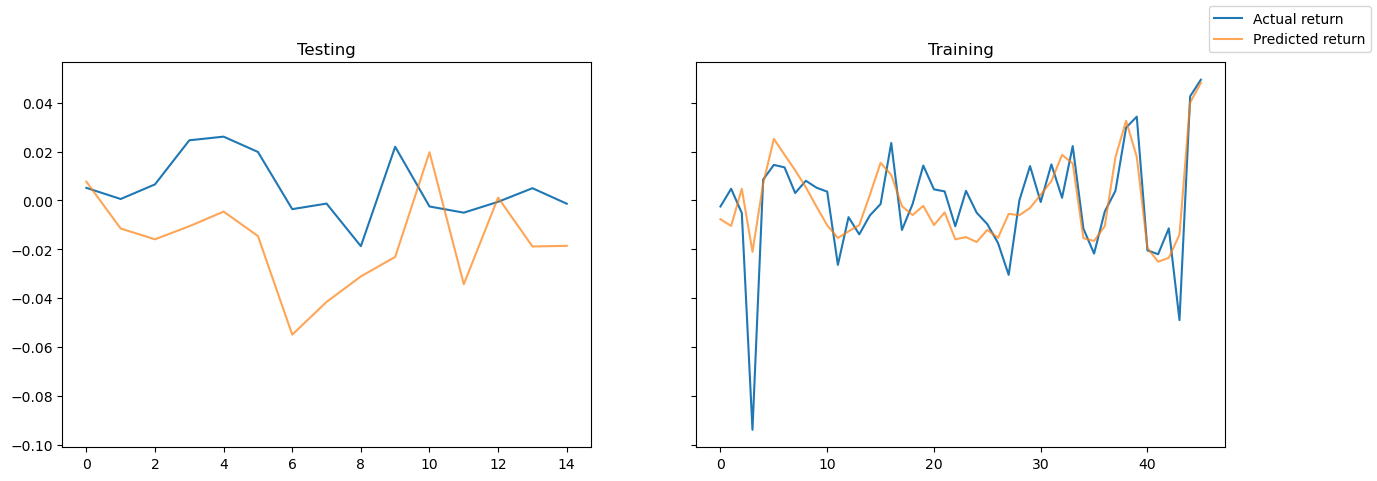

META
Train RMSE is 0.037 and Test RMSE is 0.012


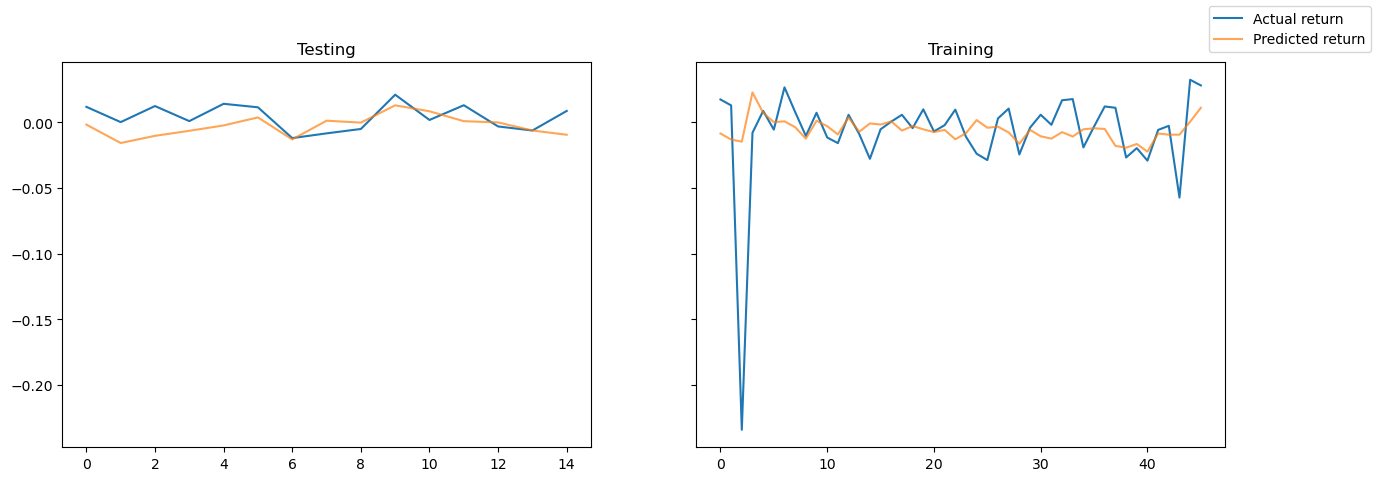

MSFT
Train RMSE is 0.004 and Test RMSE is 0.013


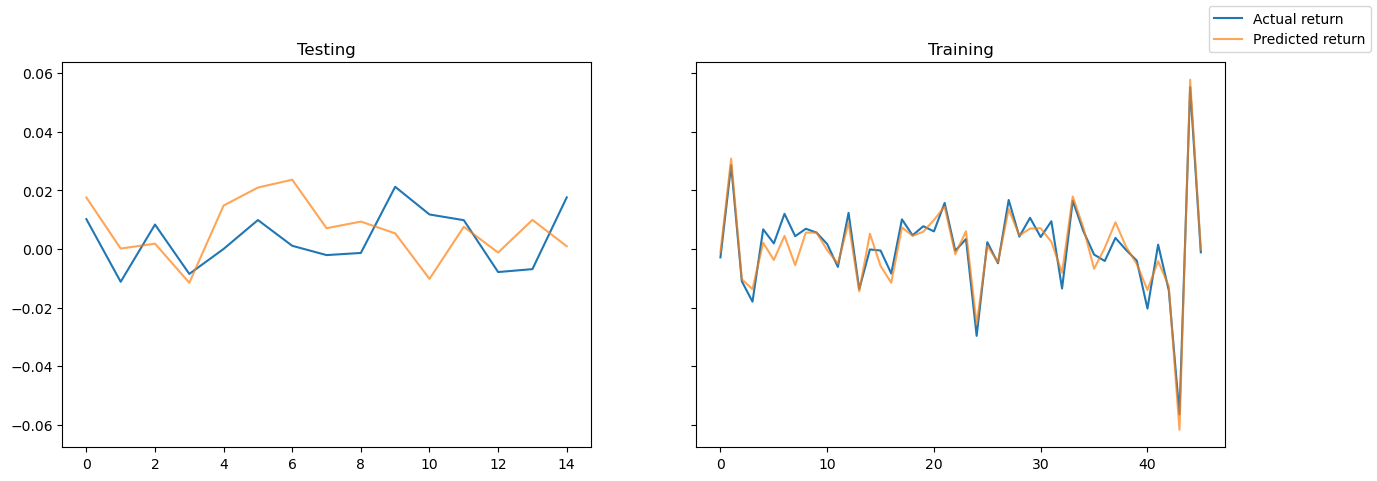

NEXT
Train RMSE is 0.021 and Test RMSE is 0.032


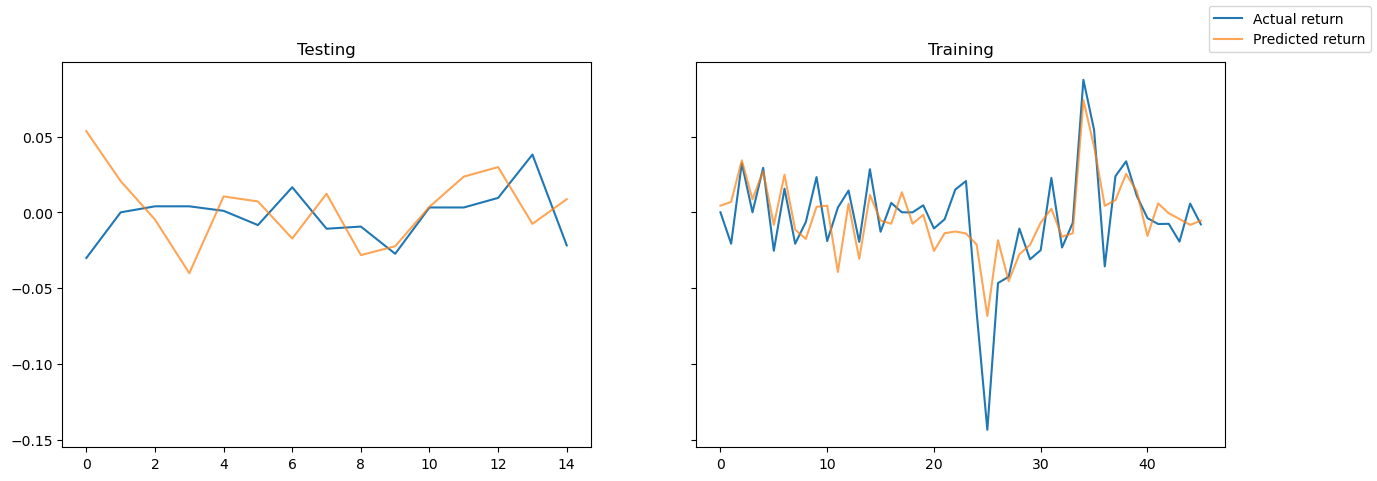

NFLX
Train RMSE is 0.006 and Test RMSE is 0.045


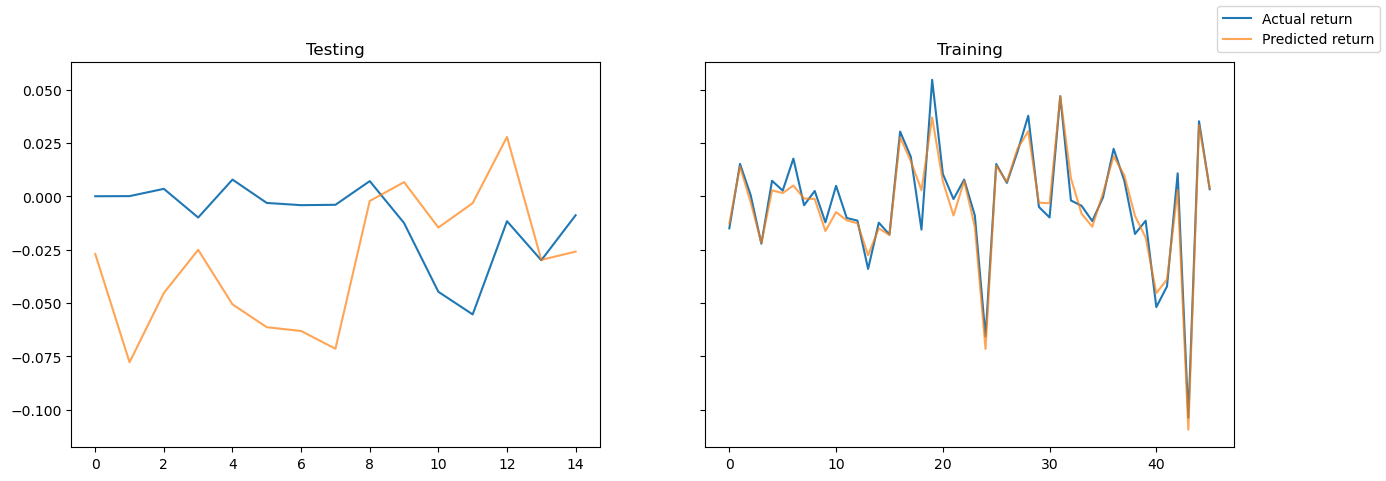

NKE
Train RMSE is 0.010 and Test RMSE is 0.011


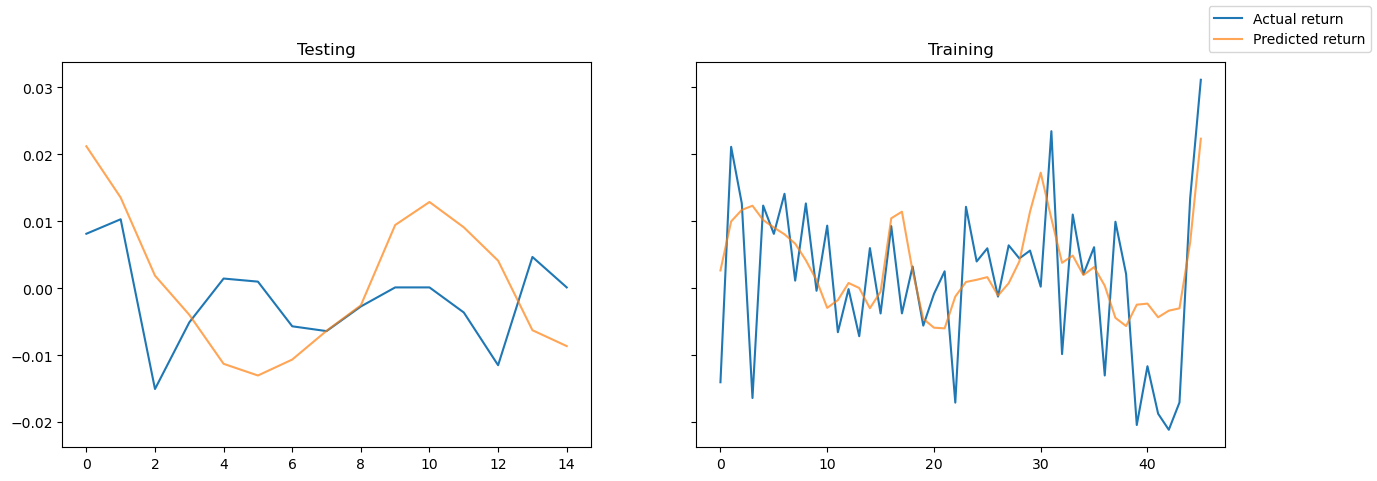

PARA
Train RMSE is 0.013 and Test RMSE is 0.013


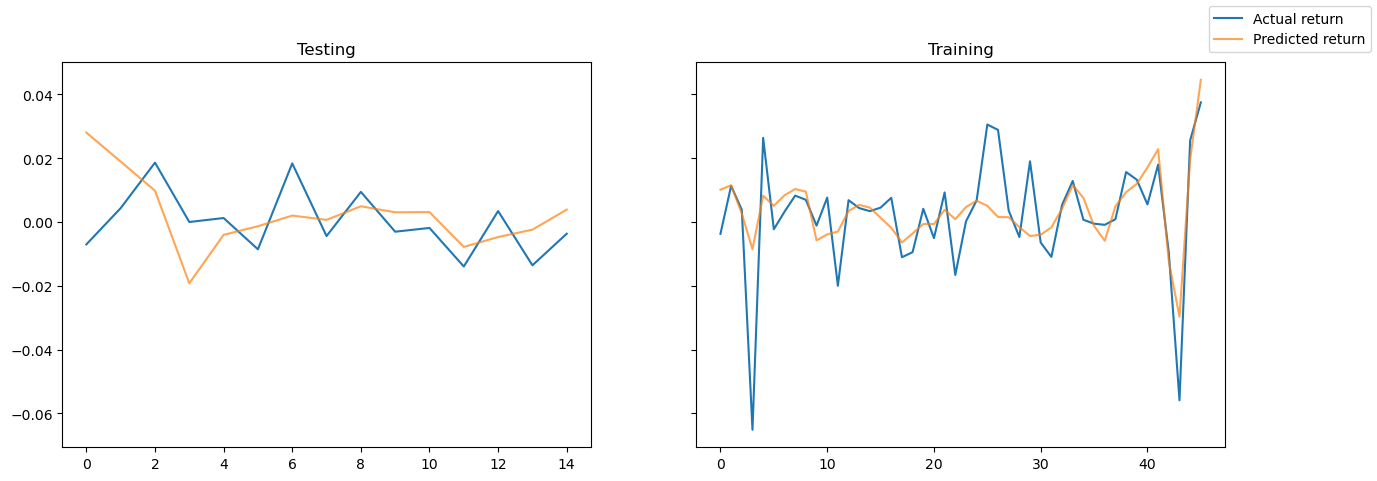

PYPL
Train RMSE is 0.009 and Test RMSE is 0.028


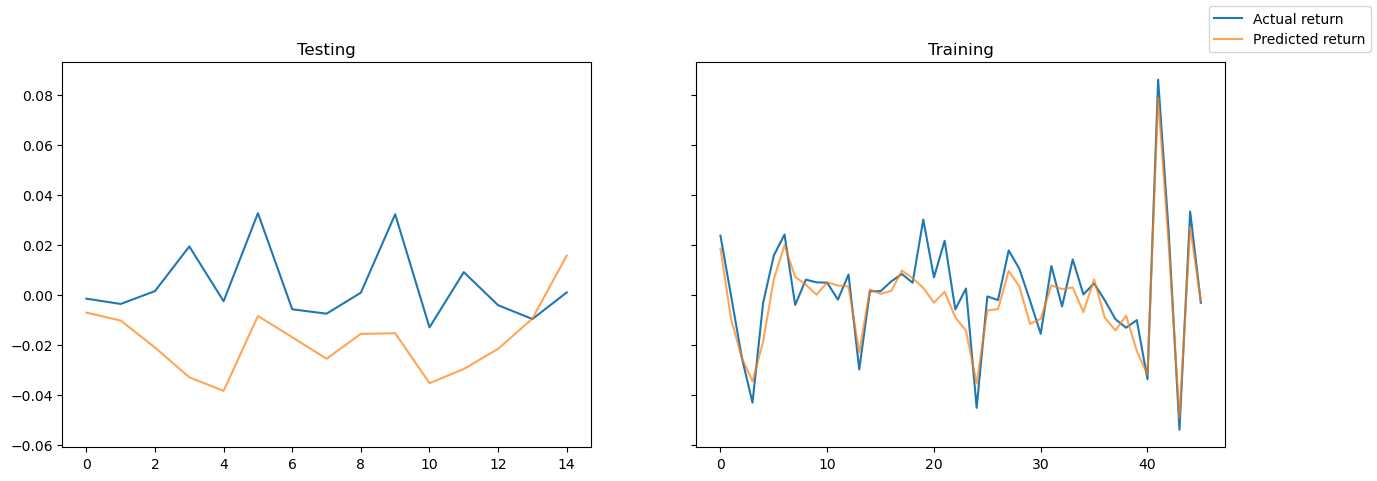

RYAAY
Train RMSE is 0.006 and Test RMSE is 0.029


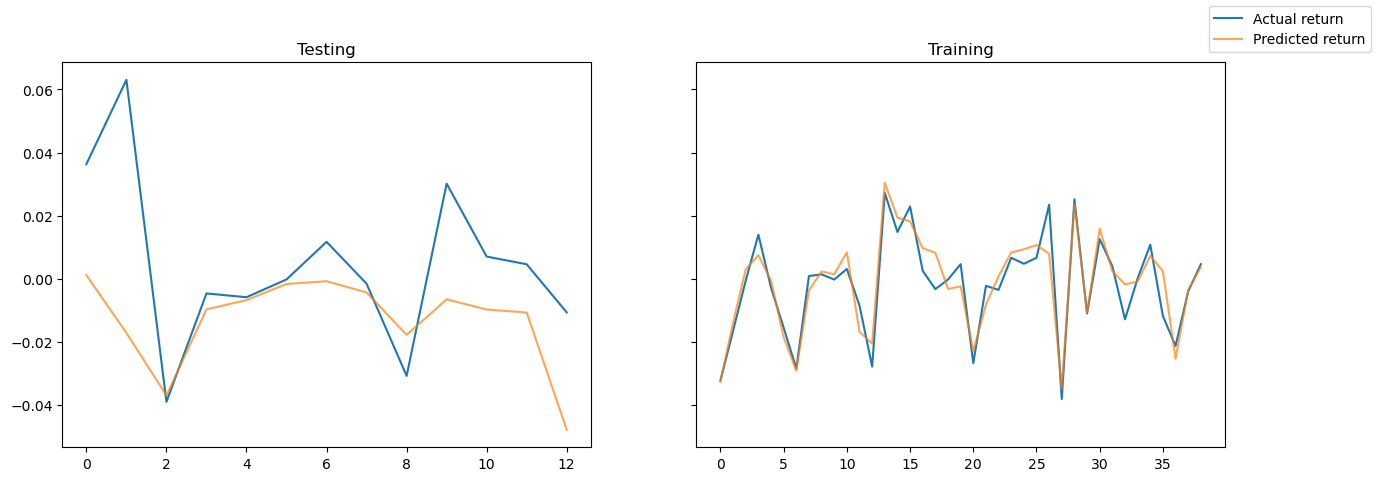

SBUX
Train RMSE is 0.005 and Test RMSE is 0.014


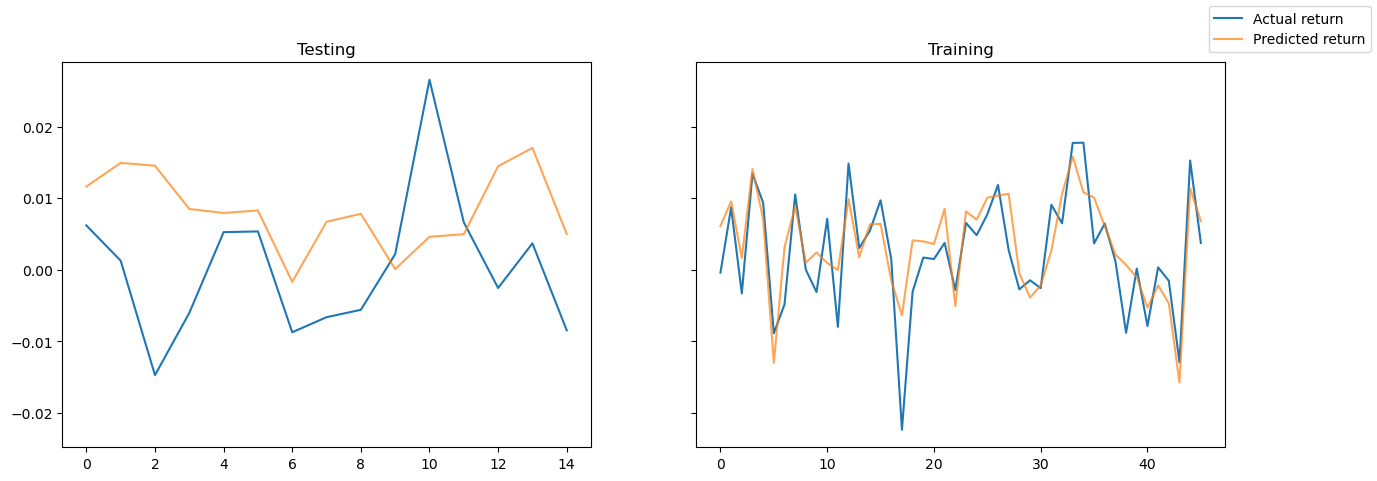

SONY
Train RMSE is 0.012 and Test RMSE is 0.033


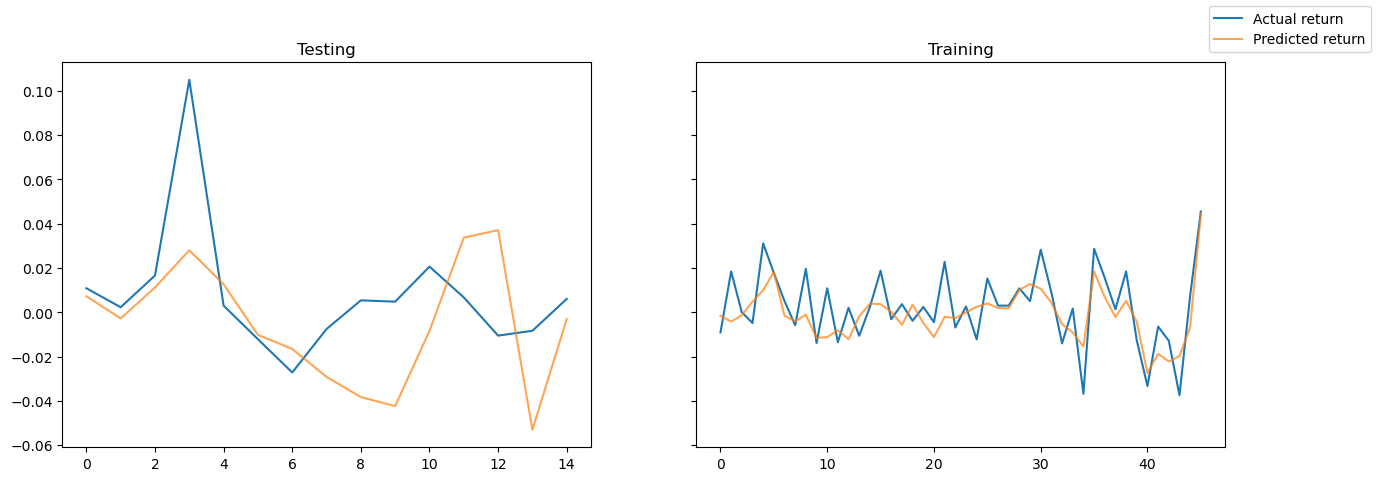

TM
Train RMSE is 0.004 and Test RMSE is 0.013


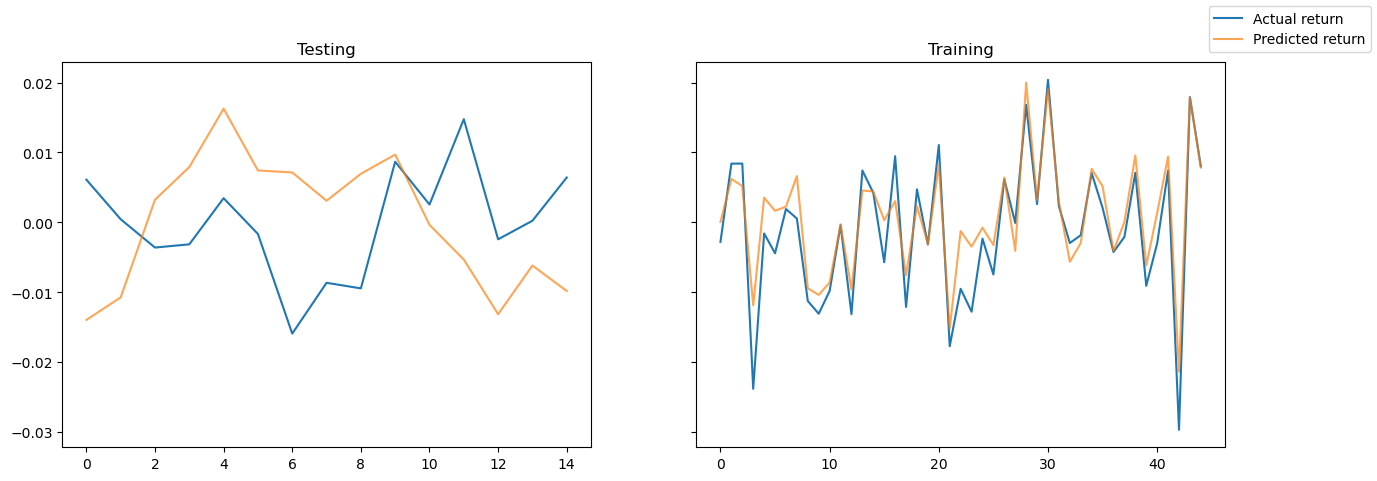

TRI
Train RMSE is 0.007 and Test RMSE is 0.024


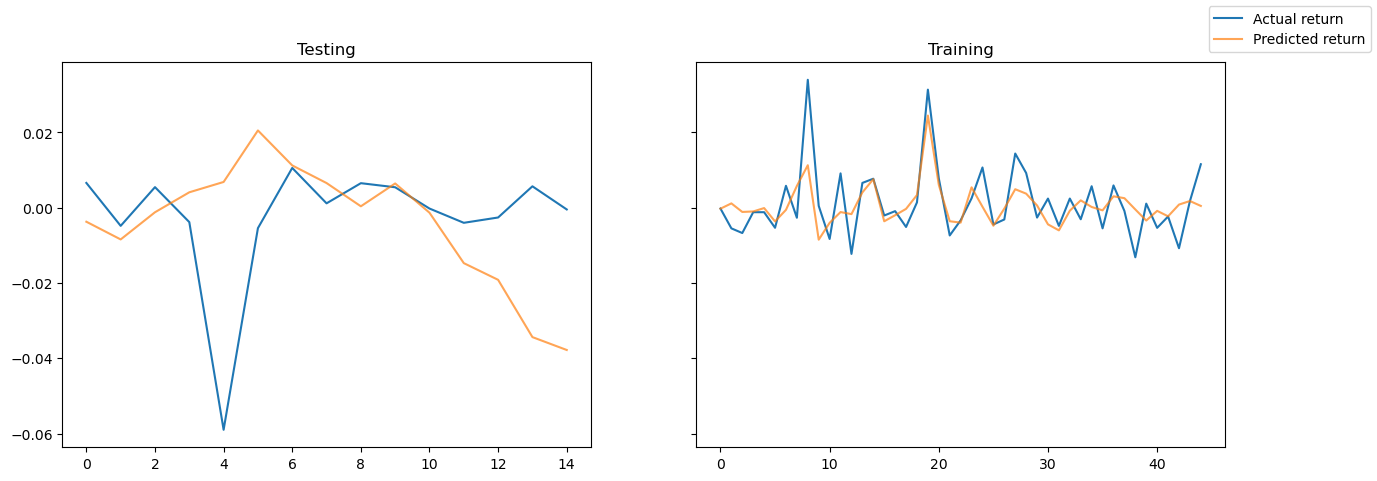

UPS
Train RMSE is 0.005 and Test RMSE is 0.010


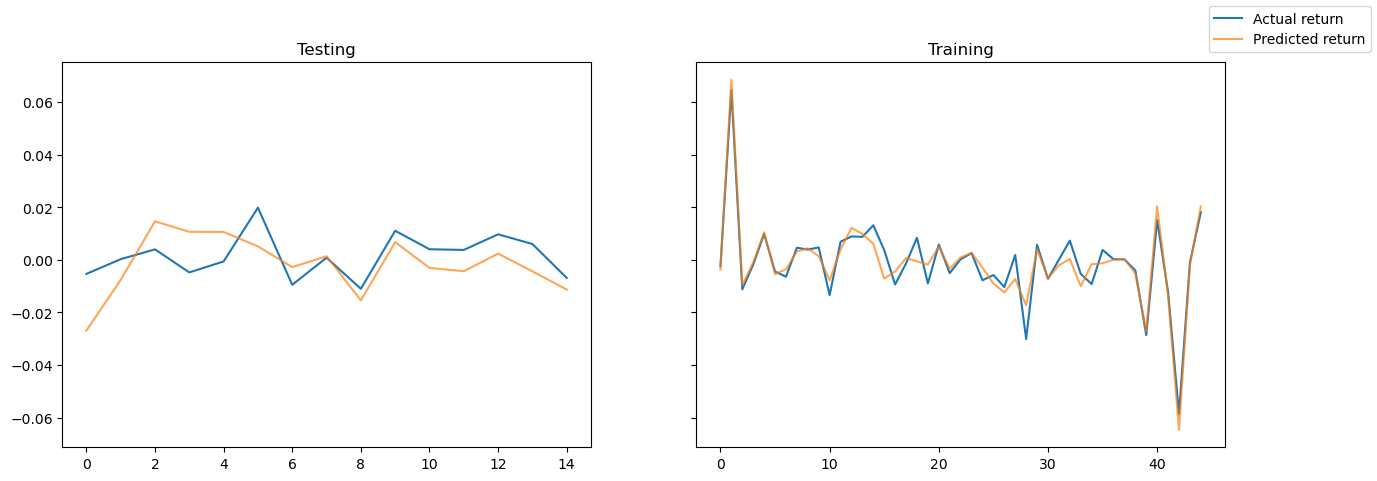

V
Train RMSE is 0.005 and Test RMSE is 0.011


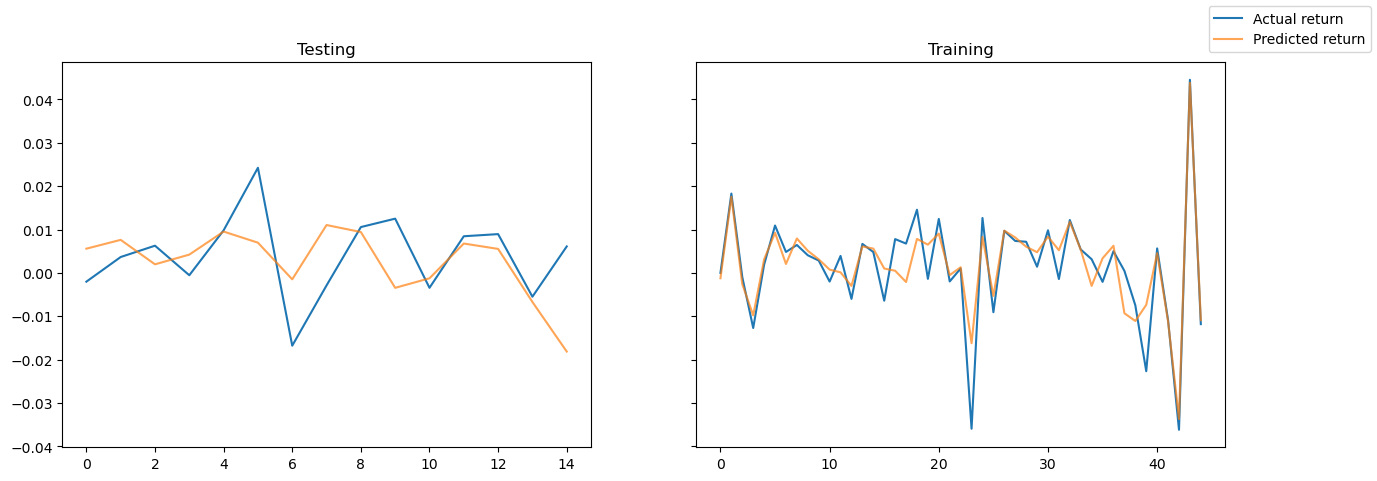

WMT
Train RMSE is 0.006 and Test RMSE is 0.007


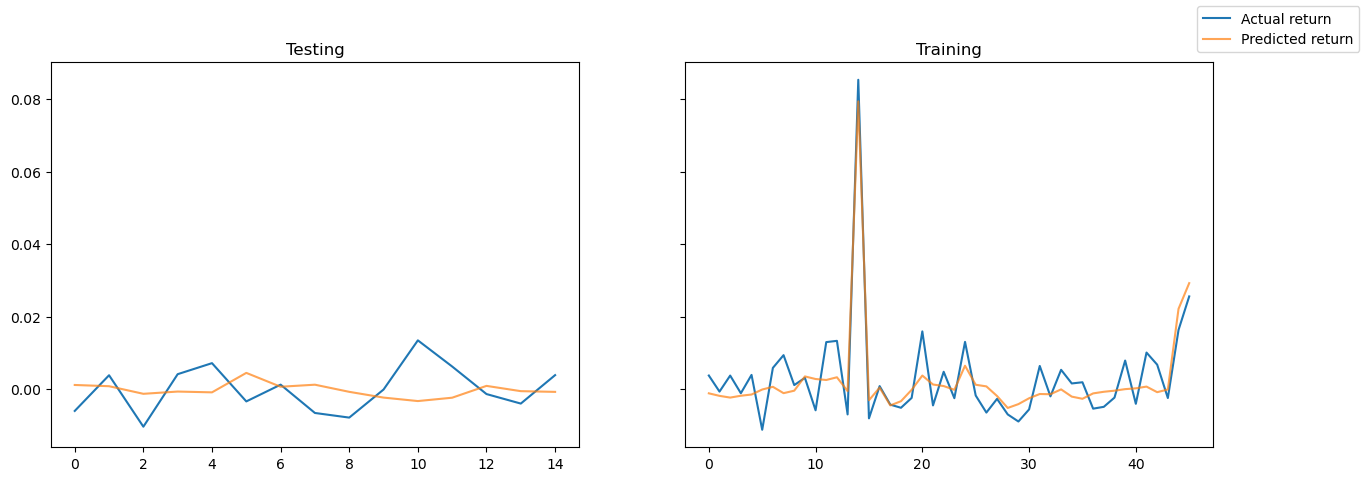

In [134]:
stock_prediction(tickers)

-----------------------------------------